In [1]:
import os

import librosa
import numpy as np
import torch
import torchaudio
from PIL import Image
from tensorflow import keras



import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Mel_Provider:
    def __init__(
        self,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        norm_mel=True,
        norm_global=False,
        device="cpu",
    ):
        self.norm_mel = norm_mel
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.norm_global = norm_global
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
            )
        else:
            self.hop_length = hop_length
        self._melspectrogram = torchaudio.transforms.MelSpectrogram(
            power=2.0,
            center=True,
            norm="slaney",
            onesided=True,
            win_length=win_length,
            pad_mode="reflect",
            n_fft=n_fft,
            n_mels=n_mels,
            sample_rate=sample_rate,
            hop_length=self.hop_length,
            f_min=min_frequency,
            f_max=max_frequency,
        ).to(self._device)

    def msg(self, wave):
        wave = torch.tensor(wave.reshape([1, -1]).astype(np.float32)).to(self._device)
        mel_spec = self._melspectrogram(wave)[0].cpu().numpy()
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel:
            mel_spec = (mel_spec - np.min(mel_spec)) / (
                np.max(mel_spec) - np.min(mel_spec)
            )
        mel_spec.astype(np.float32)
        return mel_spec

In [36]:
class MEL_Generator_Short(keras.utils.Sequence):
    def __init__(
        self,
        df,
        n_mels,
        sample_rate,
        mel_image_size,
        signal_lenght,
        n_classes,
        seed,
        img_dtype="uint8",
        secondary_coeff=0.4,
        mel_provider=Mel_Provider,
        return_primary_labels=False,
        return_concat_labels=True,
        convert_to_rgb=True,
        norm_mel=True,
        wave_dir=None,
        short_mel_dir=None,
        batch_size=32,
        shuffle=True,
        augment=None,
        sample_weight=False,
    ):
        self.mel_provider = mel_provider
        self.df = df.reset_index(drop=True)
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.signal_lenght = signal_lenght
        self.wave_dir = wave_dir
        self.short_mel_dir = short_mel_dir
        self.norm_mel = norm_mel
        self.convert_to_rgb = convert_to_rgb
        self.sample_weight = sample_weight
        self.batch_size = batch_size
        self._shuffle = shuffle
        self.return_primary_labels = return_primary_labels
        self.return_concat_labels = return_concat_labels
        self.n_classes = n_classes
        self.seed = seed
        self.augment = augment
        self.img_dtype = img_dtype
        self.secondary_coeff = secondary_coeff
        if self._shuffle:
            self._shuffle_samples()
        if self.short_mel_dir is not None:
            if not os.path.exists(self.short_mel_dir):
                os.mkdir(self.short_mel_dir)
        if self.wave_dir is not None:
            if not os.path.exists(self.wave_dir):
                os.mkdir(self.wave_dir)


    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def get_audio(
        self,
        file_path,
        end_sec=None,
    ):
        file_name = file_path.split("/")[-1][:-4]
        try:
            wave = np.load(self.wave_dir + file_name + ".npy")
        except:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)
            if not os.path.isfile(self.wave_dir + file_name + ".npy"):
                np.save(self.wave_dir + file_name, wave)
     
        if end_sec is not None:
            if end_sec < self.signal_lenght:
                end_sec = self.signal_lenght
            end = int(end_sec * self.sample_rate)
            end = end if end < len(wave) else len(wave) - 100
            start = int(end - (self.signal_lenght * self.sample_rate))
            if start < 0:
                start = 0
                end = self.signal_lenght * self.sample_rate
            wave = wave[start:end]
        return wave

    def on_epoch_start(self):
        if self._shuffle:
            self._shuffle_samples()

    def __getitem__(self, batch_ix):
        if self.img_dtype == "uint8":
            b_X = np.zeros(
                (self.batch_size, self.mel_image_size, self.mel_image_size, 3),
                dtype=np.uint8,
            )
        else:
            b_X = np.zeros(
                (self.batch_size, self.mel_image_size, self.mel_image_size, 3),
                dtype=np.float32,
            )

        b_Y = np.zeros(
            (self.batch_size, self.n_classes),
            dtype=np.float16,
        )

        for i in range(self.batch_size):
            b_X[i], b_Y[i] = self._get_one(
                i + self.batch_size * batch_ix,
            )

        return b_X, b_Y

    def sin_cos(self, mel_spec, ix):
        if self.img_dtype == "uint8":
            max_value = 255
        else:
            max_value = 1
        min_value = 0
        #         sin_month
        mel_spec[self.mel_image_size - 10 :, :20, 0] = (
            max_value * self.df.loc[ix, "sin_month"]
        )
        mel_spec[self.mel_image_size - 10 :, :20, 1] = max_value
        mel_spec[self.mel_image_size - 10 :, :20, 2] = max_value
        #         cos_month
        mel_spec[self.mel_image_size - 10 :, 20:40, 0] = max_value
        mel_spec[self.mel_image_size - 10 :, 20:40, 1] = (
            max_value * self.df.loc[ix, "cos_month"]
        )
        mel_spec[self.mel_image_size - 10 :, 20:40, 2] = max_value
        #         year
        mel_spec[self.mel_image_size - 10 :, 40:60, 0] = max_value
        mel_spec[self.mel_image_size - 10 :, 40:60, 1] = max_value
        mel_spec[self.mel_image_size - 10 :, 40:60, 2] = (
            max_value * (2021 - self.df.loc[ix, "year"]) / 50
        )
        #         sin_longitude
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 60 : self.mel_image_size - 40,
            0,
        ] = (
            max_value * self.df.loc[ix, "sin_longitude"]
        )
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 60 : self.mel_image_size - 40,
            1,
        ] = max_value
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 60 : self.mel_image_size - 40,
            2,
        ] = max_value
        #         cos_longitude
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 40 : self.mel_image_size - 20,
            0,
        ] = max_value
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 40 : self.mel_image_size - 20,
            1,
        ] = (
            max_value * self.df.loc[ix, "cos_longitude"]
        )
        mel_spec[
            self.mel_image_size - 10 :,
            self.mel_image_size - 40 : self.mel_image_size - 20,
            2,
        ] = max_value
        #         norm_latitude
        mel_spec[self.mel_image_size - 10 :, self.mel_image_size - 20 :, 0] = max_value
        mel_spec[self.mel_image_size - 10 :, self.mel_image_size - 20 :, 1] = max_value
        mel_spec[self.mel_image_size - 10 :, self.mel_image_size - 20 :, 2] = (
            max_value * self.df.loc[ix, "norm_latitude"]
        )
        return mel_spec

    def _get_one(self, ix):
        file_path = self.df.loc[ix, "file_path"]
        rating = self.df.loc[ix, "rating"]
        label_id = self.df.loc[ix, "label_id"]
        end_sec = self.df.loc[ix, "end_sec"]
        file_name = self.df.loc[ix, "filename"][:-4]
        new_filename = self.df.loc[ix, "row_id"]

        try:
            if not self.augment:
                mel_spec = np.load(self.short_mel_dir + new_filename + ".npy")
            else:
                mel_spec = None
        except:
            mel_spec = None
        if mel_spec is None:
            wave = self.get_audio(file_path, end_sec)
            mel_spec = self.mel_provider.msg(wave)

            if mel_spec.shape != (self.mel_image_size, self.mel_image_size):
                mel_spec = Image.fromarray(mel_spec)
                mel_spec = mel_spec.resize(
                    (self.mel_image_size, self.mel_image_size),
                    Image.BICUBIC,
                )
                mel_spec = np.array(mel_spec)

            if self.convert_to_rgb:
                if self.img_dtype == "uint8":
                    mel_spec = np.round(mel_spec * 255)
                    mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.uint8), 2), 3, 2)
                else:
                    mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.float32), 2), 3, 2)
                mel_spec = self.sin_cos(mel_spec, ix)
            if not self.augment:
                if not os.path.isfile(self.short_mel_dir + new_filename + ".npy"):
                    np.save(self.short_mel_dir + new_filename, mel_spec)



        primary_y = np.zeros(self.n_classes)
        secondary_y = np.zeros(self.n_classes)
        assert (
            self.return_primary_labels + self.return_concat_labels == 1
        ), "only one of return_primary_labels or return_concat_labels can be True"

        primary_y[label_id] = 1
        if self.return_primary_labels:
            y = primary_y
        if type(self.df.loc[ix, "secondary_labels_id"]) == float:
            secondary_y = secondary_y
        else:
            for i in self.df.loc[ix, "secondary_labels_id"].split(" "):
                i = int(i)
                secondary_y[i] = self.secondary_coeff

        if self.return_concat_labels:
            y = primary_y + secondary_y
            y = np.where(y > 1, 1, y)

        # sample weight
        if self.sample_weight:
            sw = self.df.loc[ix, "class_weights"] * rating  

        assert mel_spec.shape == (self.n_mels, self.mel_image_size, 3) or (
            self.n_mels,
            self.mel_image_size,
        )
        return mel_spec, y

    def _shuffle_samples(self):
        self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(drop=True)

In [37]:
all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")

In [38]:
data = pd.read_csv("/app/_data/labels_nocall/all_calls.csv")
data = data[~data['file_path'].str.contains('soundscapes')].sample(100)
data = data[["filename", "row_id", "start_sec", "end_sec", "birds", "duration"]]

In [39]:
data = data.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "file_path",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "norm_latitude",
            "label_id",
            "secondary_labels_id",
        ]
    ],
    on="filename",
    how="left",
)

In [40]:
data['end_sec'] = data['end_sec']-0.05

In [41]:
mel_pr = Mel_Provider(
    n_fft=2024,
    win_length=1024,
    n_mels=224,
    sample_rate=32000,
    mel_image_size=224,
    min_frequency=0,
    max_frequency=16000,
    signal_lenght=5,
)

In [42]:
gen = MEL_Generator_Short(
    df=data,
    n_mels=224,
    seed=42,
    sample_rate=32000,
    mel_image_size=224,
    batch_size=25,
    n_classes=398,
    signal_lenght=5,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
)

In [43]:
# for i in tqdm(range(10000)):
a = gen.__getitem__(3)

In [44]:
a[0][0]
a[1][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

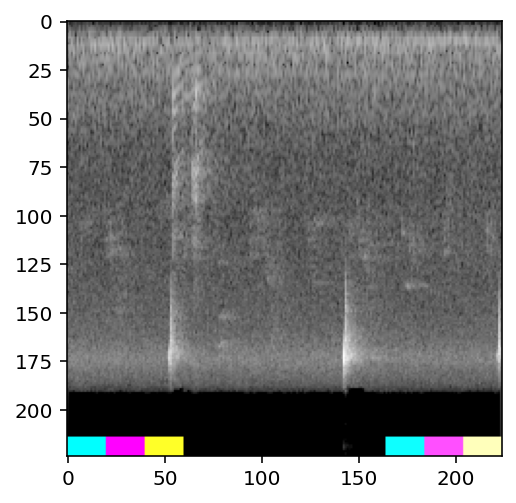

In [35]:
plt.imshow(a[0][0])